In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import Imputer

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA, KernelPCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.feature_selection import SelectFromModel

from scipy.stats import skew
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('ggplot')

In [2]:
train = pd.read_csv("data/data.csv")
test = pd.read_csv("data/test.csv")

# 去掉噪声
train.drop(train[(train["GrLivArea"]>4000) & (train["SalePrice"]<300000)].index, inplace=True)
train.drop(train[(train["OverallQual"]<5) & (train["SalePrice"]>200000)].index, inplace=True)

# 将测试集和训练集合并在一起
data = pd.concat([train,test], ignore_index=True)
data.drop(['Id'],axis=1, inplace=True)
print("data shape:", data.shape)

data shape: (2916, 80)


## 数据清洗

In [3]:
# 空值填充
data["LotAreaCut"] = pd.qcut(data.LotArea,10)    # 新增一列，按照LotArea均分为10等份
data['LotFrontage']=data.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

cols = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols:
    data[col].fillna(0, inplace=True)
    
cols1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols1:
    data[col].fillna("None", inplace=True)

cols2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols2:
    data[col].fillna(data[col].mode()[0], inplace=True)
data.drop(['LotAreaCut'],axis=1, inplace=True)

In [4]:
# 过滤数据集中各特征列含有的空值，按照空值数量降序排列
def getnullcount():
    x = data.isnull().sum()
    print("有空值的列：", x[x>0].sort_values(ascending=False))
    #x[x>0].sort_values(ascending=False).plot.bar()

getnullcount()

有空值的列： SalePrice    1459
dtype: int64


## 特征工程

In [5]:
NumStr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold","YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]
for col in NumStr:
    data[col] = data[col].astype(str)

In [6]:
# 离散化
def map_values():
    data["oMSSubClass"] = data.MSSubClass.map({'180':1, 
                                        '30':2, '45':2, 
                                        '190':3, '50':3, '90':3, 
                                        '85':4, '40':4, '160':4, 
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})
    
    data["oMSZoning"] = data.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    
    data["oNeighborhood"] = data.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    data["oCondition1"] = data.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})
    data["oBldgType"] = data.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})
    
    data["oHouseStyle"] = data.HouseStyle.map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    data["oExterior1st"] = data.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})
    
    data["oMasVnrType"] = data.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    data["oExterQual"] = data.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFoundation"] = data.Foundation.map({'Slab':1, 
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})
    
    data["oBsmtQual"] = data.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oBsmtExposure"] = data.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})
    
    data["oHeating"] = data.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})
    
    data["oHeatingQC"] = data.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oKitchenQual"] = data.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
    
    data["oFunctional"] = data.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    data["oFireplaceQu"] = data.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    data["oGarageType"] = data.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})
    
    data["oGarageFinish"] = data.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    data["oPavedDrive"] = data.PavedDrive.map({'N':1, 'P':2, 'Y':3})
    
    data["oSaleType"] = data.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})
    
    data["oSaleCondition"] = data.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})            
                              
    return "Done!"

map_values()

'Done!'

In [7]:
# 年份做LabelEncoder
lab = LabelEncoder()
data["YearBuilt"] = lab.fit_transform(data["YearBuilt"])
data["YearRemodAdd"] = lab.fit_transform(data["YearRemodAdd"])
data["GarageYrBlt"] = lab.fit_transform(data["GarageYrBlt"])

In [8]:
data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,oHeating,oHeatingQC,oKitchenQual,oFunctional,oFireplaceQu,oGarageType,oGarageFinish,oPavedDrive,oSaleType,oSaleCondition
0,856,854,0,None,3,1Fam,TA,No,706.0,0.0,...,5,5,3,3,1,4,3,3,1,3
1,1262,0,0,None,3,1Fam,TA,Gd,978.0,0.0,...,5,5,2,3,3,4,3,3,1,3
2,920,866,0,None,3,1Fam,TA,Mn,486.0,0.0,...,5,5,3,3,3,4,3,3,1,3
3,961,756,0,None,3,1Fam,Gd,No,216.0,0.0,...,5,4,3,3,4,2,2,3,1,2
4,1145,1053,0,None,4,1Fam,TA,Av,655.0,0.0,...,5,5,3,3,3,4,3,3,1,3


In [9]:
# 增加组合特征
def mix_features(X):
    X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
    X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

    X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
    X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
    X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
    X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
    X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
    X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
    X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
    X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
    X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

    X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
    X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
    X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
    X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
    X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
    X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]

    X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
    X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
    X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]

    return X

data = mix_features(data)
## 删除标签SalePrice
data.drop(['SalePrice'], axis=1, inplace=True)
print("删除标签后的所有数据集Shape:", data.shape)

删除标签后的所有数据集Shape: (2916, 122)


In [10]:
data_numeric = data.select_dtypes(exclude=["object"])
data_numeric.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,-_oFunctional_TotalHouse,-_oFunctional_OverallQual,-_LotArea_OverallQual,-_TotalHouse_LotArea,-_oCondition1_TotalHouse,-_oCondition1_OverallQual,Bsmt,Rooms,PorchArea,TotalPlace
0,856,854,0,706.0,0.0,150.0,0,0,2,548.0,...,7698.0,10,59150,11016.0,7698.0,10,856.0,10,61,3175.0
1,1262,0,0,978.0,0.0,284.0,0,1,2,460.0,...,7572.0,9,57600,12124.0,5048.0,8,1262.0,8,0,2984.0
2,920,866,0,486.0,0.0,434.0,0,1,2,608.0,...,8118.0,10,78750,13956.0,8118.0,10,920.0,8,42,3356.0
3,961,756,0,216.0,0.0,540.0,272,1,1,642.0,...,7419.0,10,66850,12023.0,7419.0,10,756.0,8,307,3422.0
4,1145,1053,0,655.0,0.0,490.0,0,1,2,836.0,...,10029.0,11,114080,17603.0,10029.0,11,1145.0,11,84,4263.0


In [11]:
# x = data_numeric.isnull().sum()
# x[x>0].sort_values(ascending=False)
# for c in data_numeric.columns:
#     print(c ,data_numeric[c].dtype)

In [12]:
skewness = data_numeric.apply(lambda x: skew(x))
skew_features_index = skewness[skewness>0.5].index
for i in skew_features_index:
    data_numeric[i] = boxcox1p(data_numeric[i], boxcox_normmax(data_numeric[i] + 1))

In [13]:
data_numeric.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,-_oFunctional_TotalHouse,-_oFunctional_OverallQual,-_LotArea_OverallQual,-_TotalHouse_LotArea,-_oCondition1_TotalHouse,-_oCondition1_OverallQual,Bsmt,Rooms,PorchArea,TotalPlace
0,5.929136,1026.391730,0.0,143.920039,0.0,30.010265,0.00000,0.000000,2,548.0,...,130.139287,10,18.883719,7.607128,156.605485,10,422.114875,2.682935,12.332474,42.926368
1,6.224032,0.000000,0.0,181.454691,0.0,44.168164,0.00000,0.903299,2,460.0,...,129.141211,9,18.811604,7.670087,127.221557,8,593.327225,2.435032,0.000000,41.966606
2,5.984244,1041.273333,0.0,110.299845,0.0,56.942683,0.00000,0.903299,2,608.0,...,133.403851,10,19.672159,7.762044,160.749823,10,449.676657,2.435032,10.085768,43.801383
3,6.017495,905.116133,0.0,61.728757,0.0,64.863757,16.02506,0.903299,1,642.0,...,127.917102,10,19.218329,7.664602,153.787819,10,378.526798,2.435032,28.142463,44.112702
4,6.150533,1273.976065,0.0,136.439658,0.0,61.217212,0.00000,0.903299,2,836.0,...,147.212746,11,20.724174,7.912488,178.342616,11,544.803093,2.791857,14.597513,47.772609


In [14]:
data_obj = data.select_dtypes(['object'])
data_obj.head()

,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,...,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,YrSold
0,None,3,1Fam,TA,No,GLQ,Unf,1.0,0.0,Gd,...,CollgCr,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2008
1,None,3,1Fam,TA,Gd,ALQ,Unf,0.0,1.0,Gd,...,Veenker,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2007
2,None,3,1Fam,TA,Mn,GLQ,Unf,1.0,0.0,Gd,...,CollgCr,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2008
3,None,3,1Fam,Gd,No,ALQ,Unf,1.0,0.0,TA,...,Crawfor,Y,None,CompShg,Gable,Abnorml,WD,Pave,AllPub,2006
4,None,4,1Fam,TA,Av,GLQ,Unf,1.0,0.0,Gd,...,NoRidge,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2008


In [18]:
data_new = data_numeric.join(data_obj)
data_new.shape

(2916, 122)

In [19]:
data_new.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities,YrSold
0,5.929136,1026.391730,0.0,143.920039,0.0,30.010265,0.00000,0.000000,2,548.0,...,CollgCr,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2008
1,6.224032,0.000000,0.0,181.454691,0.0,44.168164,0.00000,0.903299,2,460.0,...,Veenker,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2007
2,5.984244,1041.273333,0.0,110.299845,0.0,56.942683,0.00000,0.903299,2,608.0,...,CollgCr,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2008
3,6.017495,905.116133,0.0,61.728757,0.0,64.863757,16.02506,0.903299,1,642.0,...,Crawfor,Y,None,CompShg,Gable,Abnorml,WD,Pave,AllPub,2006
4,6.150533,1273.976065,0.0,136.439658,0.0,61.217212,0.00000,0.903299,2,836.0,...,NoRidge,Y,None,CompShg,Gable,Normal,WD,Pave,AllPub,2008


In [20]:
# 离散特征one_hot化
data_dummies = pd.get_dummies(data_new)
print("ONE_HOT后Shape:", data_dummies.shape)

ONE_HOT后Shape: (2916, 426)


In [21]:
data_dummies.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,EnclosedPorch,Fireplaces,FullBath,GarageArea,...,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa,YrSold_2006,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010
0,5.929136,1026.391730,0.0,143.920039,0.0,30.010265,0.00000,0.000000,2,548.0,...,1,0,1,1,0,0,0,1,0,0
1,6.224032,0.000000,0.0,181.454691,0.0,44.168164,0.00000,0.903299,2,460.0,...,1,0,1,1,0,0,1,0,0,0
2,5.984244,1041.273333,0.0,110.299845,0.0,56.942683,0.00000,0.903299,2,608.0,...,1,0,1,1,0,0,0,1,0,0
3,6.017495,905.116133,0.0,61.728757,0.0,64.863757,16.02506,0.903299,1,642.0,...,1,0,1,1,0,1,0,0,0,0
4,6.150533,1273.976065,0.0,136.439658,0.0,61.217212,0.00000,0.903299,2,836.0,...,1,0,1,1,0,0,0,1,0,0


## 划分训练集和测试集

In [22]:
n_train = train.shape[0]
print("训练集样本数:", n_train)
X_train = data_dummies[:n_train]
X_test = data_dummies[n_train:]
y_train = train.SalePrice

# RobustScaler
scaler = RobustScaler()
X_train_scaler = scaler.fit(X_train).transform(X_train)
y_train_log = np.log1p(y_train)
y_trian_10000 = np.array(y_train)/10000
X_test_scaler = scaler.transform(X_test)

print("缩放后的训练集特征:", X_train_scaler.shape)
print("Log后的训练集标签:", y_train_log.shape, y_train_log[0:5])
print("除以10000后的训练集标签:", y_trian_10000.shape, y_trian_10000[0:5])
print("缩放后的测试集特征:", X_test_scaler.shape)

训练集样本数: 1457
缩放后的训练集特征: (1457, 426)
Log后的训练集标签: (1457,) 0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64
除以10000后的训练集标签: (1457,) [20.85 18.15 22.35 14.   25.  ]
缩放后的测试集特征: (1459, 426)


In [25]:
X_train_scaler.shape

(1457, 426)

## 模型训练
## 对于log后的标签
- 所有特征来一遍（各种模型分数，各种模型调参后的分数，模型融合之后的分数）
- 特征选择来一遍
- PCA后来一遍
- PCA后特征选择来一遍

## 对于除以10000以后的标签
- 重复上述


In [26]:
def rand_search(model, paras, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    grid = RandomizedSearchCV(model,
                              param_distributions=paras,
                              cv=5, 
                              scoring='neg_mean_squared_error',
                              n_jobs=-1)
    grid.fit(X_train, y_train)
    print("BestParams:{} BestScore:{}".format(grid.best_params_, np.sqrt(-grid.best_score_)))
    grid.cv_results_['mean_test_score'] = np.sqrt(-grid.cv_results_['mean_test_score'])
    print(pd.DataFrame(grid.cv_results_)[['params', 'mean_test_score', 'std_test_score']])

In [27]:
model_paras_dic = {
    Lasso(): {'alpha': [0.0004,0.0005,0.0007,0.0009],'max_iter':[10000]},
    Ridge(): {'alpha':[35,40,45,50,55,60,65,70,80,90]},
    KernelRidge(): {'alpha':[0.2, 0.3, 0.4], 'kernel':["polynomial"], 'degree':[2,3],'coef0':[0.8, 1]},
    ElasticNet(): {'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[7000, 10000]}, 
    SVR(): {'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}, 
    XGBRegressor(objective='reg:linear'): {'n_estimators': range(2000,5000, 50),'max_depth': range(2,10,1),
        'subsample': [0.7, 0.8], 'colsample_bytree':[0.6, 0.7, 0.8], 'learning_rate': [0.0005, 0.001, 0.005],
        'reg_alpha': [0.0005, 0.0006, 0.001]},
    LGBMRegressor(objective='regression'): {'n_estimators': range(2000,5000, 50), 'max_depth': range(2,10,1),
        'subsample': [0.7, 0.8], 'colsample_bytree':[0.6, 0.7, 0.8], 'learning_rate': [0.0005, 0.001, 0.005],
        'reg_alpha': [0.0005, 0.0006, 0.001]},
}

In [28]:
for model, params in model_paras_dic.items():
    print("Model:", model)
    rand_search(model, params, X_train_scaler, y_train_log)
    print("-"*50)

Model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
BestParams:{'max_iter': 10000, 'alpha': 0.0009} BestScore:0.11141410216527584
                                 params  mean_test_score  std_test_score
0  {'max_iter': 10000, 'alpha': 0.0004}         0.112202        0.001657
1  {'max_iter': 10000, 'alpha': 0.0005}         0.111811        0.001737
2  {'max_iter': 10000, 'alpha': 0.0007}         0.111636        0.001823
3  {'max_iter': 10000, 'alpha': 0.0009}         0.111414        0.001808
--------------------------------------------------
Model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
BestParams:{'alpha': 70} BestScore:0.11082564171740891
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.111181        0.001827
1  {'al

## 得到较优参数的模型

In [29]:
model_names = ["LR", "Lasso", "Ridge", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb", "Lgb"]
models = [
          LinearRegression(),
          Lasso(alpha=0.0009,max_iter=10000),
          Ridge(alpha=70),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          SVR(C=11, kernel='rbf',gamma=0.0003, epsilon=0.009),
          LinearSVR(),
          ElasticNet(alpha=0.004,max_iter=10000),
          SGDRegressor(max_iter=1000,tol=1e-3),
          BayesianRidge(),
          KernelRidge(alpha=0.2, kernel='polynomial', degree=2, coef0=1),
          ExtraTreesRegressor(),
          XGBRegressor(objective='reg:linear', colsample_bytree=0.7, learning_rate=0.005,
                           max_depth=4,n_estimators=4600, subsample=0.7,reg_alpha=0.0005,nthread=32),
          LGBMRegressor(objective='regression', colsample_bytree=0.7,learning_rate=0.005,
                            max_depth=4, n_estimators=4200,subsample=0.7,reg_alpha=0.0006,nthread=32)
          
         ]


In [30]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [31]:
for name, model in zip(model_names, models):
    score = rmse_cv(model, X_train_scaler, y_train_log)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(),score.std()))

# LR: 0.129535, 0.0139
# Lasso: 0.109920, 0.0047
# Ridge: 0.112116, 0.0049
# RF: 0.137144, 0.0055
# GBR: 0.121360, 0.0053
# SVR: 0.165964, 0.0124
# LinSVR: 0.263480, 0.1398
# Ela: 0.115605, 0.0039
# SGD: 2045688552883054.000000, 2783736987195132.5000
# Bay: 0.112134, 0.0055
# Ker: 0.498722, 0.4712
# Extra: 0.132911, 0.0085
# Xgb: 0.112510, 0.0061
# Lgb: 0.120568, 0.0042


LR: 15182948.520700, 30365896.7807
Lasso: 0.108800, 0.0051
Ridge: 0.109884, 0.0052
RF: 0.139314, 0.0058
GBR: 0.121641, 0.0042
SVR: 0.108774, 0.0069
LinSVR: 0.131545, 0.0150
Ela: 0.112391, 0.0041
SGD: 0.294066, 0.0262
Bay: 0.110285, 0.0061
Ker: 0.109558, 0.0060
Extra: 0.127639, 0.0087
Xgb: 0.112578, 0.0062
Lgb: 0.118657, 0.0045


In [32]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self, mod, weight):
        self.mod = mod
        self.weight = weight
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.mod]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])
        for data in range(pred.shape[1]):
            single = [pred[model, data]*weight for model, weight in zip(range(pred.shape[0]), self.weight)]
            w.append(np.sum(single))
        return w

In [41]:
w1,w2,w3,w4,w5,w6,w7,w8 = [0.1, 0.1, 0.1, 0.2, 0.1, 0.1, 0.1, 0.2]
lr,lasso,ridge, rf,gbr,svr,lsvr,ela,sgd,bay,ker,ext,xgb,lgb = models
avg_model = AverageWeight(mod=[lasso, ridge, gbr, svr, ela, bay, xgb, ker],weight=[w1,w2,w3,w4,w5,w6,w7,w8])
score = rmse_cv(avg_model,X_train_scaler, y_train_log)
print(score.mean())

0.1070957822617434


In [42]:
avg2 = AverageWeight(mod=[svr, ker], weight=[0.5,0.5])
score2 = rmse_cv(avg2,X_train_scaler, y_train_log)
print(score2.mean())
## 贝叶斯和xgb一起表现还不错

0.10783414670196836


## Stacking

In [36]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [37]:
X_train_stack = Imputer().fit_transform(X_train_scaler)
y_train_stack_log = Imputer().fit_transform(y_train_log.values.reshape(-1,1)).ravel()
print(X_train_stack.shape, y_train_stack_log.shape)

(1457, 426) (1457,)


In [43]:
stack_model = stacking(mod=[lasso, ridge, gbr, ela, bay, ker, xgb], meta_model=svr)
score3 = rmse_cv(stack_model,X_train_stack,y_train_stack_log)
print(score3.mean())
# 0.114

0.10892400666871875


## stacking 提取特征

In [44]:
X_train_stack_features, X_test_stack_features = stack_model.get_oof(X_train_stack, y_train_stack_log, X_test_scaler)

In [46]:
print(X_train_stack.shape, X_train_stack_features.shape)
X_train_add = np.hstack((X_train_stack, X_train_stack_features))
X_test_add = np.hstack((X_test_scaler, X_test_stack_features))
print("合并后的特征:", X_train_add.shape, X_test_add.shape)
stack_model2 = stacking(mod=[lasso, ridge, gbr, svr, ela, bay, ker, xgb], meta_model=svr)
score4 = rmse_cv(stack_model2,X_train_add, y_train_stack_log)
print(score4.mean())

(1457, 426) (1457, 7)
合并后的特征: (1457, 433) (1459, 433)
0.11001788713529881


## 特征选择

In [63]:
def features_select(select_model, model, X, y):
    select_model.fit(X, y)
    print("最初特征维数:", len(select_model.feature_importances_))
    thresholds = [i for i in select_model.feature_importances_ if i >1e-6]
    print("去掉权重接近0的特征维数:", len(thresholds))
    threshs = thresholds[:int(len(thresholds)/2)]
    threshs = list(set(thresholds))
    threshs.sort()
    print("去重后特征维数:", len(threshs))
    for thresh in threshs:
        selection = SelectFromModel(select_model, threshold=thresh, prefit=True)
        X_train_select = selection.transform(X)
        new_model = model
        score = rmse_cv(new_model, X_train_select, y)
        print("Thresh:{} 特征维数:{}".format(thresh, X_train_select.shape[1]))
        print("{}: {:.6f}, {:.4f}".format(new_model, score.mean(),score.std()))
        print("-"*50)

In [64]:
select_model = XGBRegressor(objective='reg:linear', colsample_bytree=0.7, learning_rate=0.005,
                           max_depth=4,n_estimators=4600, subsample=0.7,reg_alpha=0.0005,nthread=32)

In [65]:
features_select(select_model, bay, X_train_scaler, y_train_log)

最初特征维数: 426
去掉权重接近0的特征维数: 326
去重后特征维数: 167
Thresh:1.849420186772477e-05 特征维数:326
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110242, 0.0061
--------------------------------------------------
Thresh:3.698840373544954e-05 特征维数:315
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110284, 0.0061
--------------------------------------------------
Thresh:5.548260742216371e-05 特征维数:304
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110195, 0.0060
------------------------------------------------

Thresh:0.0005363318487070501 特征维数:218
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110649, 0.0051
--------------------------------------------------
Thresh:0.0005548260523937643 特征维数:214
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110467, 0.0051
--------------------------------------------------
Thresh:0.0005733202560804784 特征维数:212
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110429, 0.0051
--------------------------------------------------
Thresh:0.0005918144597671926 特征维数:210
Ba

Thresh:0.0011281463084742427 特征维数:152
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110387, 0.0050
--------------------------------------------------
Thresh:0.0011466405121609569 特征维数:149
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110237, 0.0051
--------------------------------------------------
Thresh:0.001165134715847671 特征维数:148
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110173, 0.0049
--------------------------------------------------
Thresh:0.0012021231232210994 特征维数:146
Bay

Thresh:0.0017569492338225245 特征维数:100
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.109786, 0.0047
--------------------------------------------------
Thresh:0.0017754434375092387 特征维数:99
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.109806, 0.0046
--------------------------------------------------
Thresh:0.001793937641195953 特征维数:98
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.110658, 0.0044
--------------------------------------------------
Thresh:0.001812431844882667 特征维数:97
Bayesia

Thresh:0.0027186477091163397 特征维数:68
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.112292, 0.0046
--------------------------------------------------
Thresh:0.0027926245238631964 特征维数:67
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.112210, 0.0046
--------------------------------------------------
Thresh:0.0028111187275499105 特征维数:66
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.112225, 0.0046
--------------------------------------------------
Thresh:0.0028296129312366247 特征维数:65
Bayesi

Thresh:0.005714708473533392 特征维数:38
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.115545, 0.0049
--------------------------------------------------
Thresh:0.0059921215288341045 特征维数:37
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.115465, 0.0048
--------------------------------------------------
Thresh:0.006140075158327818 特征维数:36
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.116478, 0.0038
--------------------------------------------------
Thresh:0.0065284534357488155 特征维数:35
Bayesian

Thresh:0.021379297599196434 特征维数:11
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.140741, 0.0041
--------------------------------------------------
Thresh:0.02145327441394329 特征维数:10
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.141397, 0.0039
--------------------------------------------------
Thresh:0.02167520485818386 特征维数:9
BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
              fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
              normalize=False, tol=0.001, verbose=False): 0.153403, 0.0046
--------------------------------------------------
Thresh:0.02259991504251957 特征维数:8
BayesianRidge(a

## PCA之后训练

In [47]:
pca = PCA(n_components=410)

In [48]:
X_train_pca = pca.fit_transform(X_train_scaler)
X_test_pca = pca.fit_transform(X_test_scaler)
print(X_train_pca.shape, X_test_pca.shape)

(1457, 410) (1459, 410)


In [49]:
for model, params in model_paras_dic.items():
    print("Model:", model)
    rand_search(model, params, X_train_pca, y_train_log)
    print("-"*50)

Model: Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
BestParams:{'max_iter': 10000, 'alpha': 0.0009} BestScore:0.1120215137881979
                                 params  mean_test_score  std_test_score
0  {'max_iter': 10000, 'alpha': 0.0004}         0.113161        0.001714
1  {'max_iter': 10000, 'alpha': 0.0005}         0.112933        0.001787
2  {'max_iter': 10000, 'alpha': 0.0007}         0.112362        0.001900
3  {'max_iter': 10000, 'alpha': 0.0009}         0.112022        0.001980
--------------------------------------------------
Model: Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
BestParams:{'alpha': 70} BestScore:0.11082564171740886
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.111181        0.001827
1  {'alp

KeyboardInterrupt: 

In [ ]:
print("PCA之后维数：", X_train_pca.shape)

In [57]:
model_names = ["LR", "Lasso", "Ridge", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb", "Lgb"]
models = [
          LinearRegression(),
          Lasso(alpha=0.0009,max_iter=10000),
          Ridge(alpha=70),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          SVR(C=11, kernel='rbf',gamma=0.0003, epsilon=0.009),
          LinearSVR(),
          ElasticNet(alpha=0.004,max_iter=7000),
          SGDRegressor(max_iter=1000,tol=1e-5),
          BayesianRidge(),
          KernelRidge(alpha=0.3, kernel='polynomial', degree=2, coef0=1),
          ExtraTreesRegressor(),
          XGBRegressor(objective='reg:linear', colsample_bytree=0.7, learning_rate=0.005,
                           max_depth=3,n_estimators=3850,subsample=0.8,reg_alpha=0.0006,nthread=32),
          LGBMRegressor(objective='regression', colsample_bytree=0.7,learning_rate=0.005,
                            max_depth=3, n_estimators=2400,subsample=0.6,reg_alpha=0.0006,nthread=32)
          
         ]


In [58]:
for name, model in zip(model_names, models):
    score = rmse_cv(model, X_train_pca, y_train_log)
    print("{}: {:.6f}, {:.4f}".format(name, score.mean(),score.std()))

LR: 59530923.310179, 78173342.6680
Lasso: 0.112299, 0.0043
Ridge: 0.112116, 0.0049
RF: 0.166842, 0.0115
GBR: 0.136530, 0.0104
SVR: 0.165964, 0.0124
LinSVR: 0.498905, 0.4065
Ela: 0.113940, 0.0042
SGD: 216602704917835.718750, 68206945724549.1641
Bay: 0.112134, 0.0055
Ker: 27.708082, 21.4610
Extra: 0.161064, 0.0102
Xgb: 0.129876, 0.0099
Lgb: 0.134058, 0.0095


In [62]:
avg_pca = AverageWeight(mod=[ela, bay], weight=[0.5,0.5])
score = rmse_cv(avg_pca, X_train_pca, y_train_log)
print(score.mean())

0.1115656742091552


In [65]:
ela.fit(X_train_pca, y_train_log)
bay.fit(X_train_pca, y_train_log)
price = np.exp(0.5*ela.predict(X_test_pca) + 0.5*bay.predict(X_test_pca))
print(price[0:5])

[118379.74688341  77117.05138775 193428.16344292 195501.43243667
 226700.93066765]


In [66]:
result = pd.DataFrame({'Id':test.Id, 'SalePrice':price})
result.to_csv("data/submission-pca410-ela-bay-0627.csv",index=False)

In [15]:
model_xgb = xgb.XGBRegressor(objective='reg:linear',
                         colsample_bytree=0.7,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3000,
                         subsample=0.7,
                         reg_alpha=0.0006,
                         nthread=6)

In [16]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [17]:
score = rmse_cv(model_xgb, X_train_scaler, y_train_log)
print("{}: {:.6f}, {:.4f}".format("XGB",score.mean(),score.std()))

XGB: 0.112421, 0.0062


In [18]:

score = rmse_cv(model_xgb, X_train_scaler, y_trian_10000)
print("{}: {:.6f}, {:.4f}".format("XGB",score.mean(), score.std()))

XGB: 2.177249, 0.1701


In [45]:
model_lgb = lgb.LGBMRegressor(objective='regression', 
                              colsample_bytree=0.7,
                              learning_rate=0.01,
                              max_depth=3,
                              n_estimators=3000,
                              subsample=0.7,
                              reg_alpha=0.0006,
                              nthread=20)

In [46]:
score = rmse_cv(model_lgb, X_train_scaler, y_train_log)
print("{}: {:.6f}, {:.4f}".format("XGB",score.mean(),score.std()))

XGB: 0.117413, 0.0057


In [47]:
def get_scores(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    model.fit(X_train, y_train)
    y_pred = model.pre

In [80]:
param_dist = {
        'objective': ['regression'],
        'n_estimators': range(2000,4000, 50),
        'max_depth': range(2,10,1),
        'subsample': [0.7, 0.8],
        'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
        'learning_rate': [0.001, 0.01, 0.1],
        'reg_alpha': [0.0005,0.0006, 0.005],
}

rand_search(lgb.LGBMRegressor(thread=32), param_dist, X_train_scaler, y_train_log)

best_estimator: LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.9,
       importance_type='split', learning_rate=0.01, max_depth=2,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=3300, n_jobs=-1, num_leaves=31, objective='regression',
       random_state=None, reg_alpha=0.0005, reg_lambda=0.0, silent=True,
       subsample=0.7, subsample_for_bin=200000, subsample_freq=0,
       thread=32)
grid.best_score_: -0.014514544955787157


In [81]:
param_dist = {
        'objective': ['reg:linear'],
        'n_estimators': range(2000,4000, 50),
        'max_depth': range(2,10,1),
        'subsample': [0.7, 0.8],
        'colsample_bytree':[0.6, 0.7, 0.8, 0.9],
        'learning_rate': [0.001, 0.01, 0.1],
        'reg_alpha': [0.0005, 0.0006],
}

rand_search(xgb.XGBRegressor(nthread=32), param_dist, X_train_scaler, y_train_log)

best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3150,
       n_jobs=1, nthread=32, objective='reg:linear', random_state=0,
       reg_alpha=0.0005, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
grid.best_score_: -0.013732771837575557


In [20]:
# 特征选择
def features_select(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
    model.fit(X_train, y_train)
    print("特征维数:", len(model.feature_importances_))
    thresholds = [i for i in model.feature_importances_ if i >1e-5]
#     
    print("去掉权重接近0的特征维数:", len(thresholds))
    # select_split = [int(i*len(thresholds)) for i in [0.05, 0.1, 0.15,0.2,0.4,0.5, 0.85, 0.9, 0.95, 0.98]]
    # threshs = [thresholds[i] for i in select_split]
    threshs = list(set(thresholds))
    threshs.sort()
    print("去重后特征维数:", len(threshs))
    for thresh in threshs:
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
#         if select_X_train.shape[1] >= 15:
        selection_model = xgb.XGBRegressor(objective='reg:linear', 
                         colsample_bytree=0.9,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3150,
                         subsample=0.8,
                         reg_alpha=0.0005,
                         nthread=32)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        print(select_X_train.shape, select_X_test.shape)
        y_pred = selection_model.predict(select_X_test)

        mse = np.sqrt(mean_squared_error(np.log(y_pred),np.log(y_test)))

        print("Thresh=%.6f, n=%d, Mse: %.6f" % (thresh, select_X_train.shape[1], mse))


In [129]:
xgb_m = xgb.XGBRegressor(objective='reg:linear', 
                         colsample_bytree=0.9,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3150,
                         subsample=0.8,
                         reg_alpha=0.0005,
                         nthread=32)
features_select(xgb_m, X_train_scaler, y_train_log) 


特征维数: 436
特征维数: 304
特征维数: 120
(1165, 304) (292, 304)
Thresh=0.000051, n=304, Mse: 0.009479
(1165, 289) (292, 289)
Thresh=0.000101, n=289, Mse: 0.009544
(1165, 271) (292, 271)
Thresh=0.000152, n=271, Mse: 0.009495
(1165, 261) (292, 261)
Thresh=0.000202, n=261, Mse: 0.009463
(1165, 242) (292, 242)
Thresh=0.000253, n=242, Mse: 0.009509
(1165, 231) (292, 231)
Thresh=0.000303, n=231, Mse: 0.009519
(1165, 226) (292, 226)
Thresh=0.000354, n=226, Mse: 0.009561
(1165, 219) (292, 219)
Thresh=0.000404, n=219, Mse: 0.009396
(1165, 212) (292, 212)
Thresh=0.000455, n=212, Mse: 0.009649
(1165, 208) (292, 208)
Thresh=0.000505, n=208, Mse: 0.009627
(1165, 202) (292, 202)
Thresh=0.000556, n=202, Mse: 0.009515
(1165, 195) (292, 195)
Thresh=0.000606, n=195, Mse: 0.009465
(1165, 186) (292, 186)
Thresh=0.000657, n=186, Mse: 0.009651
(1165, 184) (292, 184)
Thresh=0.000707, n=184, Mse: 0.009593
(1165, 177) (292, 177)
Thresh=0.000758, n=177, Mse: 0.009562
(1165, 173) (292, 173)
Thresh=0.000809, n=173, Mse: 0.0

In [31]:
models = [
          LinearRegression(),
          Ridge(),
          Lasso(alpha=0.01,max_iter=10000),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          SVR(),
          LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),
          SGDRegressor(max_iter=1000,tol=1e-3),
          BayesianRidge(),
          KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),
          xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.9, learning_rate=0.01,
                           max_depth=3,n_estimators=3150,subsample=0.8,reg_alpha=0.0005,nthread=32),
          lgb.LGBMRegressor(objective='regression', colsample_bytree=0.8,learning_rate=0.01,
                            max_depth=2, n_estimators=3300,subsample=0.7,reg_alpha=0.0005,nthread=20)
          
         ]
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb", "Lgb"]

def train(names, models, X,y):
    for name, model in zip(names, models):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
        m = xgb.XGBRegressor(objective='reg:linear', 
                         colsample_bytree=0.9,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3150,
                         subsample=0.8,
                         reg_alpha=0.0005,
                         nthread=32)
        m.fit(X_train, y_train)
        # print("特征维数:", len(m.feature_importances_))
        thresholds = [i for i in m.feature_importances_ if i >1e-5]     
        # print("去掉权重接近0的特征维数:", len(thresholds))
        # select_split = [int(i*len(thresholds)) for i in [0.05, 0.1, 0.15,0.2,0.4,0.5, 0.85, 0.9, 0.95, 0.98]]
        # threshs = [thresholds[i] for i in select_split]
        threshs = list(set(thresholds))
        threshs.sort()
        # print("去重后特征维数:", len(threshs))
#         for thresh in [0.000051, 0.000404]:
        thresh = 0.000404
        selection = SelectFromModel(m, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X)
        selection_model = model
        selection_model.fit(select_X_train, y)
        score = rmse_cv(model, select_X_train, y)
        print("Thresh:{}  特征维数:{}  Name: {}: {:.6f}, {:.4f}".format(thresh, select_X_train.shape[1], 
                                                                    name, score.mean(), score.std()))
        print("-"*50)

In [26]:
train(names, models, X_train_scaler, y_train_log)

特征维数: 436
去掉权重接近0的特征维数: 304
去重后特征维数: 120
Thresh: 5.1e-05
特征维数: 289
LR: 0.124383, 0.0098
--------------------------------------------------
Thresh: 0.000404
特征维数: 219
LR: 0.118422, 0.0069
--------------------------------------------------
特征维数: 436
去掉权重接近0的特征维数: 304
去重后特征维数: 120
Thresh: 5.1e-05
特征维数: 289
Ridge: 0.117042, 0.0080
--------------------------------------------------
Thresh: 0.000404
特征维数: 219
Ridge: 0.115726, 0.0061
--------------------------------------------------
特征维数: 436
去掉权重接近0的特征维数: 304
去重后特征维数: 120
Thresh: 5.1e-05
特征维数: 289
Lasso: 0.123256, 0.0052
--------------------------------------------------
Thresh: 0.000404
特征维数: 219
Lasso: 0.123256, 0.0052
--------------------------------------------------
特征维数: 436
去掉权重接近0的特征维数: 304
去重后特征维数: 120
Thresh: 5.1e-05
特征维数: 289
RF: 0.140216, 0.0086
--------------------------------------------------
Thresh: 0.000404
特征维数: 219
RF: 0.140650, 0.0084
--------------------------------------------------
特征维数: 436
去掉权重接近0的特征维数: 304
去重后特征维数:

In [32]:
mods = [
    ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000),
    xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.9, learning_rate=0.01,
                           max_depth=3,n_estimators=3150,subsample=0.8,reg_alpha=0.0005,nthread=32),
    lgb.LGBMRegressor(objective='regression', colsample_bytree=0.8,learning_rate=0.01,
                            max_depth=2, n_estimators=3300,subsample=0.7,reg_alpha=0.0005,nthread=20)]
name_list = ["Ela", "XGBoost", "LightGBM"]
train(name_list, mods, X_train_scaler, y_train_log)

Thresh:0.000404  特征维数:219  Name: Ela: 0.111877, 0.0044
--------------------------------------------------
Thresh:0.000404  特征维数:219  Name: XGBoost: 0.113748, 0.0057
--------------------------------------------------
Thresh:0.000404  特征维数:219  Name: LightGBM: 0.118420, 0.0044
--------------------------------------------------


In [45]:
def pred_data(names, models, X,y, X_test_scaler):
    preds_list = []
    for name, model in zip(names, models):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2019)
        m = xgb.XGBRegressor(objective='reg:linear', 
                         colsample_bytree=0.9,
                         learning_rate=0.01,
                         max_depth=3,
                         n_estimators=3150,
                         subsample=0.8,
                         reg_alpha=0.0005,
                         nthread=32)
        m.fit(X_train, y_train)
        # print("特征维数:", len(m.feature_importances_))
        thresholds = [i for i in m.feature_importances_ if i >1e-5]     
        # print("去掉权重接近0的特征维数:", len(thresholds))
        # select_split = [int(i*len(thresholds)) for i in [0.05, 0.1, 0.15,0.2,0.4,0.5, 0.85, 0.9, 0.95, 0.98]]
        # threshs = [thresholds[i] for i in select_split]
        threshs = list(set(thresholds))
        threshs.sort()
        # print("去重后特征维数:", len(threshs))
#         for thresh in [0.000051, 0.000404]:
        thresh = 0.000051
        selection = SelectFromModel(m, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X)
        selct_X_test = selection.transform(X_test_scaler)
        selection_model = model
        selection_model.fit(select_X_train, y)
        
        preds = selection_model.predict(selct_X_test)
        preds_list.append(preds)
        score = rmse_cv(model, select_X_train, y)
        
        print("Thresh:{}  特征维数:{}  Name: {}: {:.6f}, {:.4f}".format(thresh, select_X_train.shape[1], 
                                                                    name, score.mean(), score.std()))
        print("-"*50)
    return preds_list

In [46]:
mods = [
    ElasticNet(alpha=0.005,l1_ratio=0.08,max_iter=10000),
    xgb.XGBRegressor(objective='reg:linear', colsample_bytree=0.9, learning_rate=0.01,
                           max_depth=3,n_estimators=3150,subsample=0.8,reg_alpha=0.0005,nthread=32),
    lgb.LGBMRegressor(objective='regression', colsample_bytree=0.8,learning_rate=0.01,
                            max_depth=2, n_estimators=3300,subsample=0.7,reg_alpha=0.0005,nthread=20)]
name_list = ["Ela", "XGBoost", "LightGBM"]
preds_res = pred_data(name_list, mods, X_train_scaler, y_train_log, X_test_scaler)

Thresh:5.1e-05  特征维数:289  Name: Ela: 0.110658, 0.0053
--------------------------------------------------
Thresh:5.1e-05  特征维数:289  Name: XGBoost: 0.113724, 0.0065
--------------------------------------------------
Thresh:5.1e-05  特征维数:289  Name: LightGBM: 0.118942, 0.0046
--------------------------------------------------


In [41]:
print(0.5*preds_res[0][0:5],preds_res[1][0:5],preds_res[2][0:5])

[5.82955263 5.96957443 6.04620721 6.10102228 6.08464271] [11.773381 11.988132 12.094743 12.17833  12.136688] [11.77798735 11.9916464  12.08852579 12.15837075 12.15498263]


In [47]:
print(np.exp(0.35*preds_res[0] + 0.3*preds_res[2]+0.35*preds_res[2])[0:5])

[124812.05612052 159330.53626941 178423.9311163  193868.94033699
 192129.49352355]


In [49]:
result=pd.DataFrame({'Id':test.Id, 'SalePrice':np.exp(0.5*preds_res[0] +0.5*preds_res[2])})
result.to_csv("data/submission-0626-avg2-thresh-0451.csv",index=False)

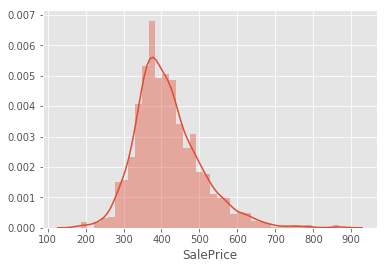

In [50]:
import seaborn as sns
sns.distplot(np.sqrt(train['SalePrice']))

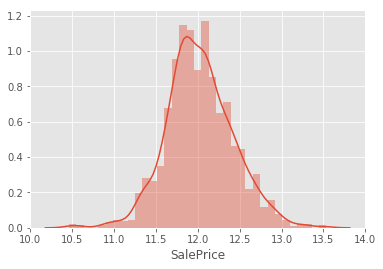

In [51]:
sns.distplot(np.log1p(train['SalePrice']))